**Importing the csv of reviews we scraped from Amazon**

In [41]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['powecom_kn95_face_mask,_disposable_masks(non_medical),_10_pack.csv']))

Saving powecom_kn95_face_mask,_disposable_masks(non_medical),_10_pack.csv to powecom_kn95_face_mask,_disposable_masks(non_medical),_10_pack (2).csv


In [42]:
df.head()

,review_date,handle,rating,helpfulness_rating,Counterfeit,review
0,8-Aug-20,S,1,3270,1,Full manufacturer name is Guangzhou Powecom La...
1,3-Aug-20,Rob F,5,1158,0,1) The Anit-Counterfeit label was vetted via t...
2,30-Jul-20,Don Germann,4,501,0,Just received the product; major concern was t...
3,28-Aug-20,Kevin Riggle,5,433,0,"Since California is on fire once again, and ea..."
4,22-Jul-20,Gale P.,2,357,0,"Even though these masks seem well made, they a..."


In [43]:
df = df.drop(df.columns[[0, 1, 3, 4]], axis=1)

In [44]:
df.head()

,rating,review
0,1,Full manufacturer name is Guangzhou Powecom La...
1,5,1) The Anit-Counterfeit label was vetted via t...
2,4,Just received the product; major concern was t...
3,5,"Since California is on fire once again, and ea..."
4,2,"Even though these masks seem well made, they a..."


**Creating a new column, rating of 4 and 5 are represented by 1. Ratings of 3 and below are represented by 0.**

In [45]:
df['rating_bin'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)

In [46]:
df.head()

,rating,review,rating_bin
0,1,Full manufacturer name is Guangzhou Powecom La...,0
1,5,1) The Anit-Counterfeit label was vetted via t...,1
2,4,Just received the product; major concern was t...,1
3,5,"Since California is on fire once again, and ea...",1
4,2,"Even though these masks seem well made, they a...",0


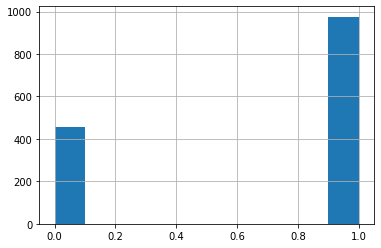

In [47]:
df['rating_bin'].hist()

**Clean and Preprocess**

In [48]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","1","2","3","4",
              "5","6","7","8","9","0","xa","le"]

for char in spec_chars:
    df['review'] = df['review'].str.replace(char, ' ')


df['review'] = df['review'].str.split().str.join(" ")

In [49]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
def tokenize_clean_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    clean_text = nltk.word_tokenize(text)
    clean_text = map(lambda x:x.lower(), clean_text)
    clean_text = [token.lower() for token in clean_text if token not in stop_words]
    clean_text = [lemmatizer.lemmatize(token) for token in clean_text]
    symbols_for_removal = "``~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    clean_text = [token for token in clean_text if token not in symbols_for_removal]
    clean_text = str(' ').join(clean_text)
    return clean_text

df['clean_review'] = df.apply(lambda row: tokenize_clean_text(row['review']), axis=1)

**Extraction with CountVectorizer**

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))

count_vectorizer.fit(df["clean_review"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

**70/30 split**

In [52]:
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['rating_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=60)

**Bag of Words training and test for CountVec**

In [53]:
def transform_data(bag_of_words, dataset):
    features = bag_of_words.transform(dataset)
    return pd.DataFrame(features.todense(), columns = bag_of_words.get_feature_names())

X_train_feats = transform_data(count_vectorizer, X_train)
X_test_feats = transform_data(count_vectorizer, X_test)

**Naive Bayes Model**

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

nb = GaussianNB()

nb.fit(X_train_feats, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
y_pred_nb = nb.predict(X_test_feats)
y_pred_nb_prob = nb.predict_proba(X_test_feats)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_prob)
roc_auc_nb = auc(fpr_nb, tpr_nb)

In [56]:
print('Naive Bayes Recall: ', round(recall_score(y_test,y_pred_nb),2))
print('Naive Bayes Precision: ', round(precision_score(y_test,y_pred_nb),2))
print('Naive Bayes F1: ', round(f1_score(y_test,y_pred_nb),2))
print('Naive Bayes Accuracy: ', round(accuracy_score(y_test,y_pred_nb),2))
print("Naive Bayes ROC AUC: %.2f" % roc_auc_nb)

Naive Bayes Recall:  0.74
Naive Bayes Precision:  0.79
Naive Bayes F1:  0.76
Naive Bayes Accuracy:  0.7
Naive Bayes ROC AUC: 0.67
